<a href="https://colab.research.google.com/github/VedantDere0104/GANs/blob/main/WGANs_with_gradient_penalty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
##################################

In [2]:
import torch
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from  torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm.auto import tqdm


In [18]:
def show_tensor_image(image_tensor , num_images , size = (1 ,28 ,28)):
  image_tensor = (image_tensor + 1) / 2
  image_unflat = image_tensor.detach().cup().view(-1 , *size)
  image_grid = make_grid(image_unflat[:num_images] , nrow=5)
  plt.imshow(image_grid.permute(1 , 2 , 0).squeeze())
  plt.show()

In [19]:
criterin = nn.BCEWithLogitsLoss()
n_epochs = 200
z_dim = 64
batch_size = 128
lr = 0.00001
beta_1 = 0.5
beta_2 = 0.999
device = 'cuda'

In [20]:
dataloader = DataLoader(MNIST('.' , download=True , transform = transforms.Compose([
                                                                                    transforms.ToTensor() , 
                                                                                    transforms.Normalize((0.5) , (0.5))
])) , batch_size = batch_size , shuffle = True)

In [98]:
class Generator(nn.Module):
  def __init__(self , z_dim = 10 , im_chan = 1 , hidden_dim = 64):
    super(Generator , self).__init__()
    self.z_dim = z_dim
    self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )


  def make_gen_block(self , input_dim ,  output_dim , kernel_size = 3 , stride = 2 , final_layer = False):
    if not final_layer:
      return nn.Sequential(
          nn.ConvTranspose2d(input_dim , output_dim , kernel_size , stride) , 
          nn.BatchNorm2d(output_dim) , 
          nn.ReLU()
      )

    else :
      return nn.Sequential(
          nn.ConvTranspose2d(input_dim , output_dim , kernel_size , stride) , 
          nn.Tanh()
      )

  def unsqueeze(self , noise):
    return noise.view(len(noise) , self.z_dim , 1 , 1)

  def forward(self , image):
    x = self.unsqueeze(image)
    return self.gen(x)
  def get_gen(self):
    return self.gen


In [99]:
def get_noise(num_images , z_dim , device):
  return torch.randn(num_images , z_dim).to(device)

In [100]:
class Critic(nn.Module):
  def __init__(self , im_chan = 1 , hidden_dim = 64 ):
    super(Critic ,self).__init__()
    self.crit = nn.Sequential(
        self.get_crit_block(im_chan , hidden_dim) , 
        self.get_crit_block(hidden_dim , hidden_dim * 2) , 
        self.get_crit_block(hidden_dim * 2 , 1 , final_layer = True)
    )

  def get_crit_block(self , input_dim , output_dim , kernel_size = 3 , stride = 2 , final_layer = False):
    if not final_layer:
      return nn.Sequential(
          nn.Conv2d(input_dim , output_dim , kernel_size , stride) , 
          nn.BatchNorm2d(output_dim) , 
          nn.LeakyReLU()
      )

    else :
      return nn.Sequential(
          nn.Conv2d(input_dim , output_dim , kernel_size , stride)
      )
  
  def forward(self , x):
    crit_pred = self.crit(x)
    return crit_pred.view(len(crit_pred) , -1)

  def get_crit(self):
    return self.crit

In [101]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters() , lr = lr , betas = (beta_1 , beta_2))
crit = Critic().to(device)
crit_opt = torch.optim.Adam(crit.parameters() , lr = lr , betas = (beta_1 , beta_2))

In [102]:
gen.get_gen()

Sequential(
  (0): Sequential(
    (0): ConvTranspose2d(64, 256, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (2): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (3): Sequential(
    (0): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2))
    (1): Tanh()
  )
)

In [103]:
crit.get_crit()

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (2): Sequential(
    (0): Conv2d(128, 1, kernel_size=(3, 3), stride=(2, 2))
  )
)

In [104]:
def weight_init(m):
  if isinstance(m , nn.Conv2d) or isinstance(m , nn.ConvTranspose2d):
    torch.nn.init.normal_(m.weight , 0.0 , 0.002)
  if isinstance(m , nn.BatchNorm2d):
    torch.nn.init.normal_(m.weight , 0.0 , 0.002)
    torch.nn.init.constant_(m.bias , 0)

In [105]:
gen = gen.apply(weight_init)
crit = crit.apply(weight_init)

In [106]:
def get_gradient(crit, real, fake, epsilon):
    '''
    Return the gradient of the critic's scores with respect to mixes of real and fake images.
    Parameters:
        crit: the critic model
        real: a batch of real images
        fake: a batch of fake images
        epsilon: a vector of the uniformly random proportions of real/fake per mixed image
    Returns:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    '''
    # Mix the images together
    mixed_images = real * epsilon + fake * (1 - epsilon)

    # Calculate the critic's scores on the mixed images
    mixed_scores = crit(mixed_images)
    
    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        # Note: You need to take the gradient of outputs with respect to inputs.
        # This documentation may be useful, but it should not be necessary:
        # https://pytorch.org/docs/stable/autograd.html#torch.autograd.grad
        #### START CODE HERE ####
        inputs=mixed_images,
        outputs=mixed_scores,
        #### END CODE HERE ####
        # These other parameters have to do with the pytorch autograd engine works
        grad_outputs=torch.ones_like(mixed_scores), 
        create_graph=True,
        retain_graph=True,
    )[0]
    return gradient

In [107]:
def gradient_penalty(gradient):
  gradient = gradient.view(len(gradient) , -1)
  gradient_norm = gradient.norm(2 , dim = 1)
  penalty = torch.mean((gradient_norm - 1) ** 2)
  return penalty

In [108]:
def get_gen_loss(critic_fake_pred):
  gen_loss = -1 * torch.mean(critic_fake_pred)
  return gen_loss

In [109]:
def get_crit_loss(crit_fake_pred , crit_real_pred , gp , c_lambda):
  crit_loss = torch.mean(crit_fake_pred) - torch.mean(crit_real_pred) + c_lambda * gp
  return crit_loss

In [110]:
c_lambda = 10
crit_repeats = 5
cur_step = 0
generator_losses = []
critic_losses = []


Step 50: Generator loss: -0.038511763717979194, critic loss: 2.2948492512702945


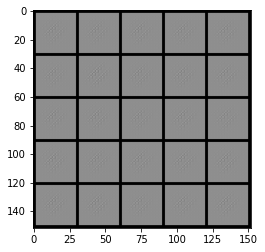

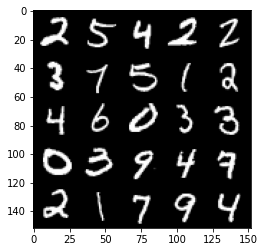

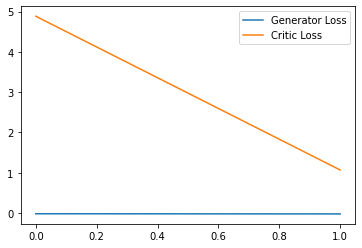

Step 100: Generator loss: -0.08150061299093067, critic loss: 0.8090587399899961


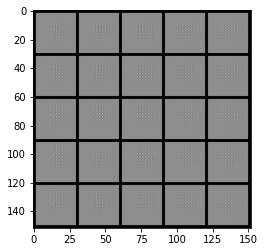

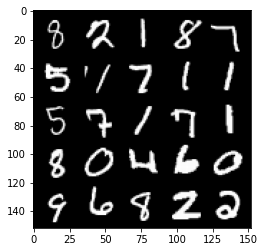

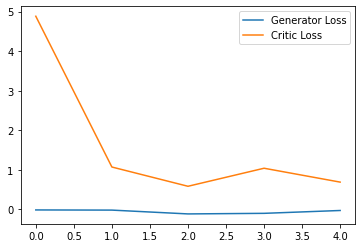

Step 150: Generator loss: -0.05385992885567248, critic loss: 0.5804229327440263


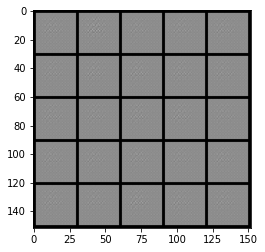

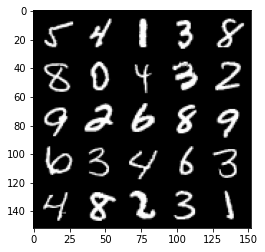

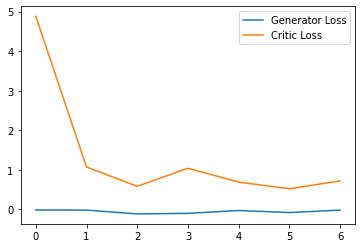

Step 200: Generator loss: -0.06070084672421217, critic loss: 0.30917662003636354


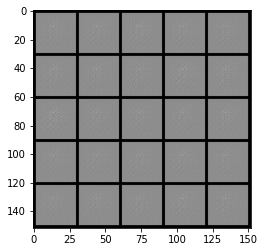

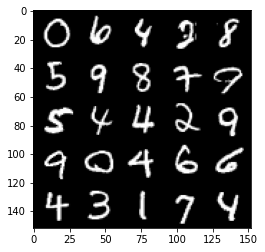

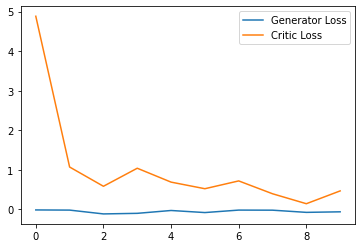

Step 250: Generator loss: -0.03298436963930726, critic loss: 0.1304276371002197


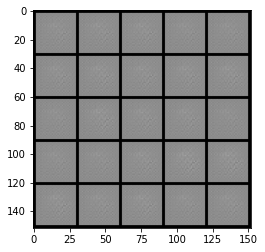

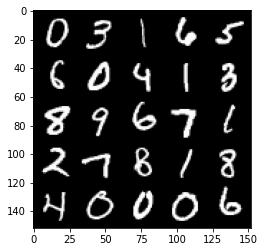

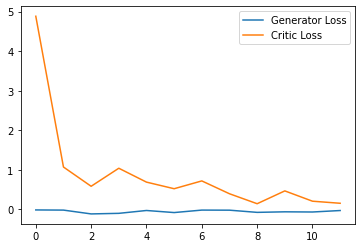

Step 300: Generator loss: 0.09462958048563451, critic loss: -0.11928050816059113


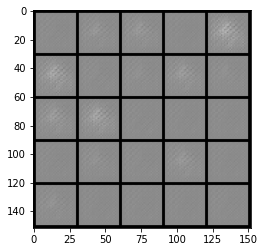

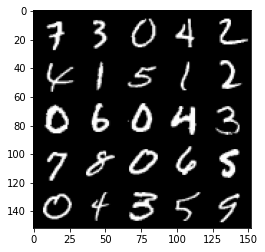

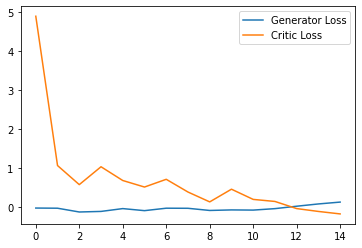

Step 350: Generator loss: 0.25146858021616936, critic loss: -0.3999497942328452


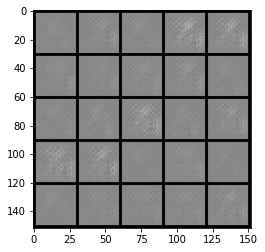

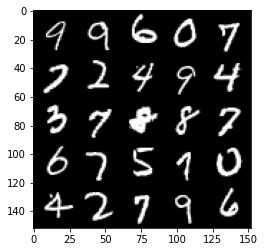

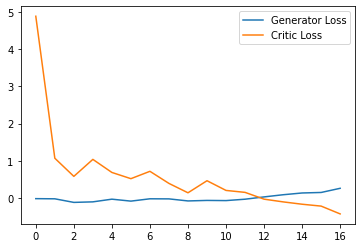

Step 400: Generator loss: 0.8675383675098419, critic loss: -1.3729307861328126


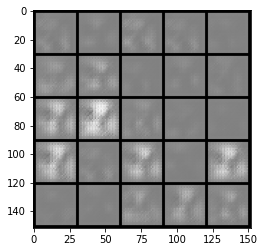

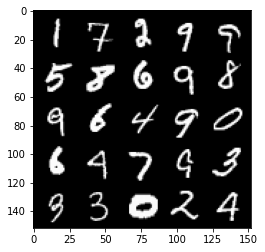

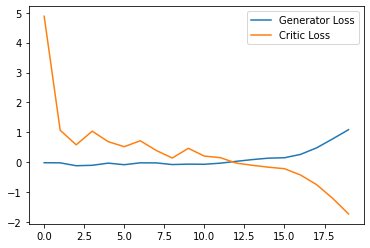

Step 450: Generator loss: 1.293112617135048, critic loss: -3.0449091620445254


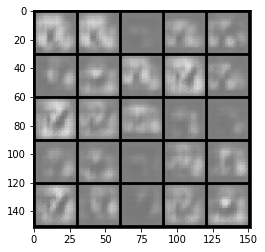

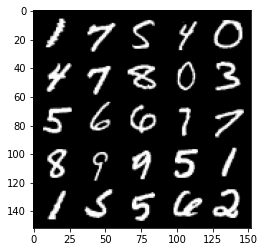

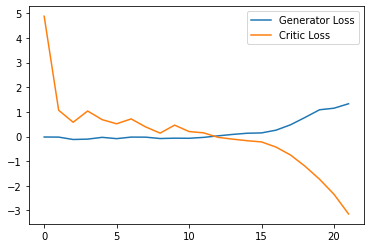

Step 500: Generator loss: 1.9322621059417724, critic loss: -6.556213975906372


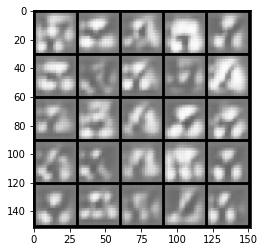

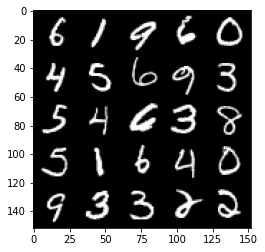

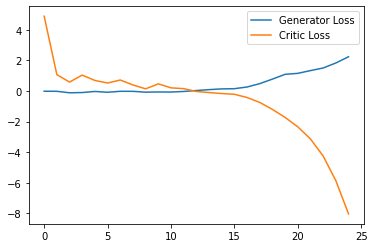

Step 550: Generator loss: 0.7029076181352139, critic loss: -12.097874748229977


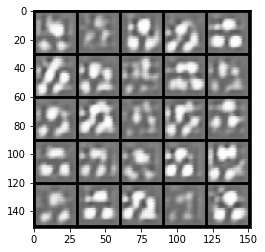

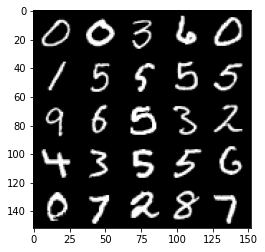

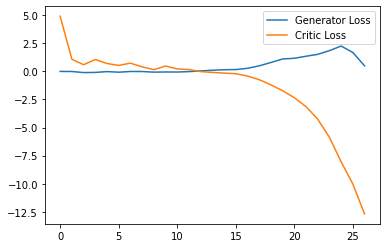

Step 600: Generator loss: 0.2226061373949051, critic loss: -20.20115118789673


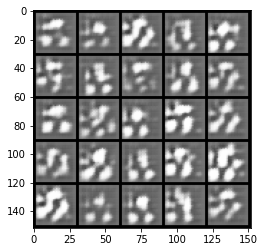

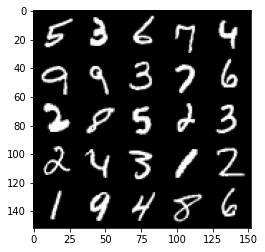

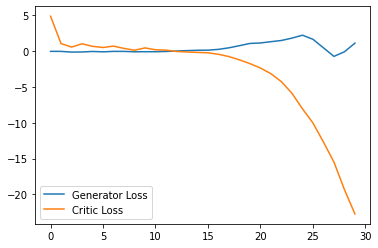

Step 650: Generator loss: -1.1070220989733934, critic loss: -26.55040780258179


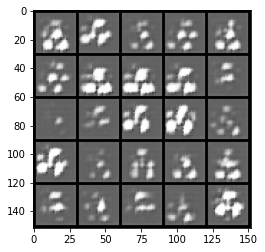

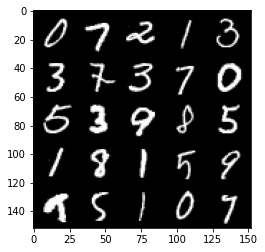

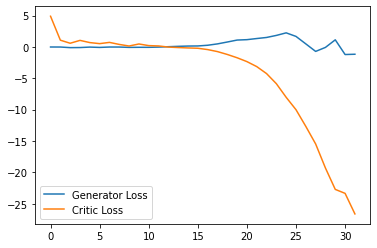

Step 700: Generator loss: -0.6510871400684118, critic loss: -36.40584722900391


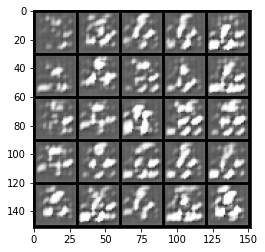

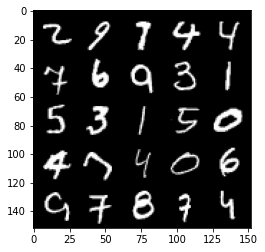

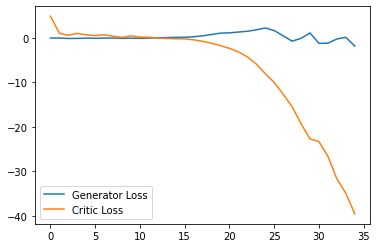

Step 750: Generator loss: -4.342708141803741, critic loss: -44.915669166564925


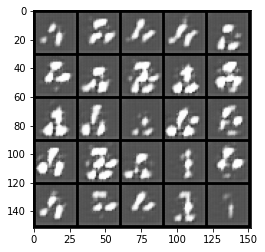

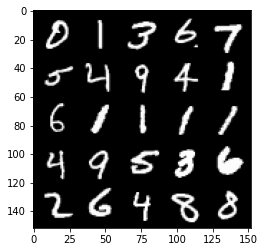

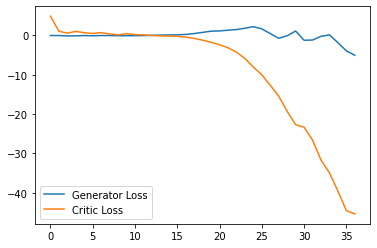

Step 800: Generator loss: -2.070401029884815, critic loss: -48.66135929489135


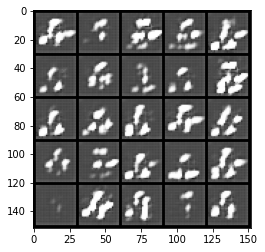

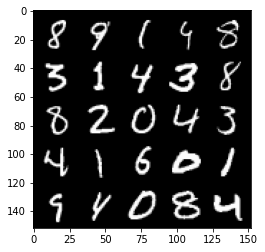

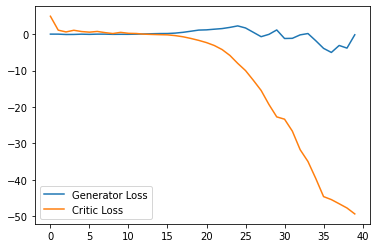

Step 850: Generator loss: -2.393761944770813, critic loss: -52.98635793304442


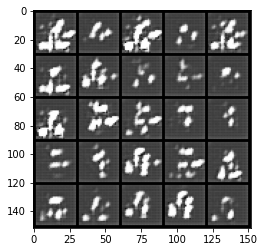

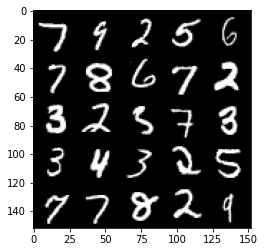

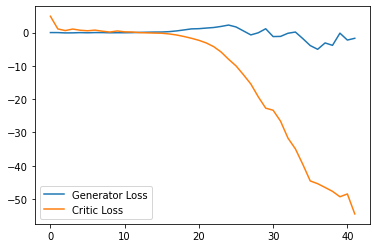

Step 900: Generator loss: -6.7732072913646695, critic loss: -54.25283194732667


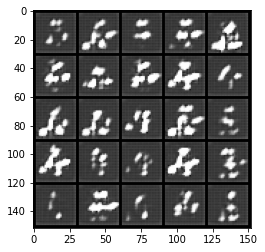

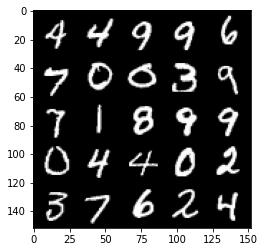

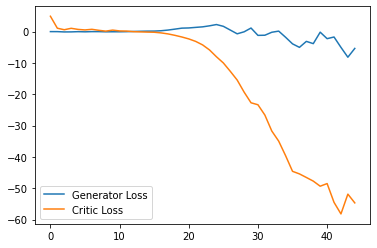

Step 950: Generator loss: -6.947721728682518, critic loss: -52.67094060897828


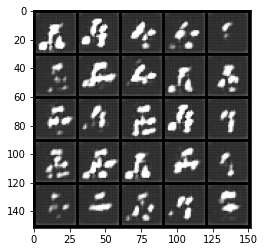

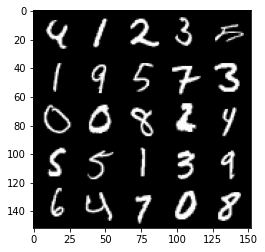

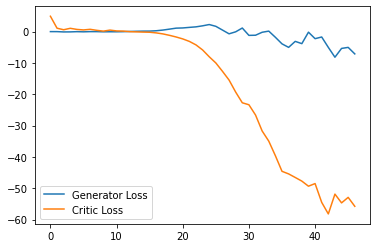

Step 1000: Generator loss: -6.735856370925903, critic loss: -50.02936296844482


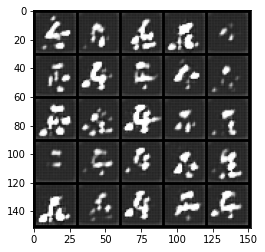

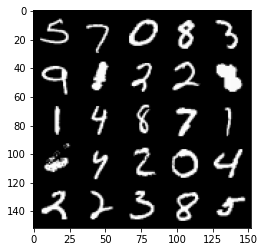

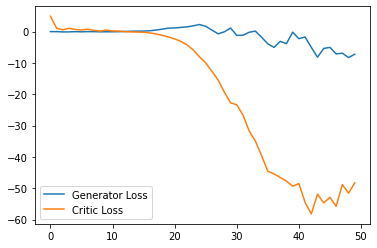

Step 1050: Generator loss: -9.983669422864914, critic loss: -38.781123092651356


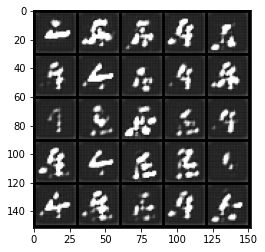

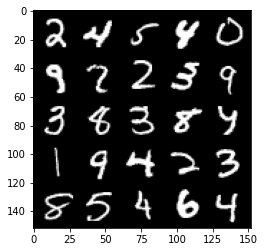

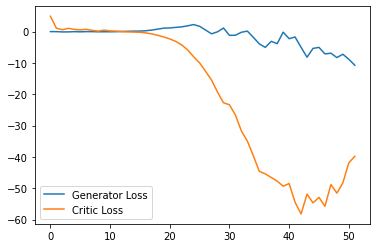

Step 1100: Generator loss: -7.720084545612335, critic loss: -37.12041366577149


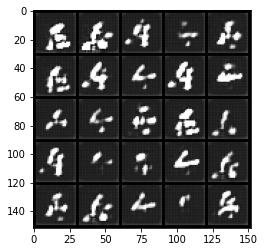

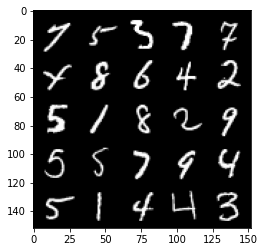

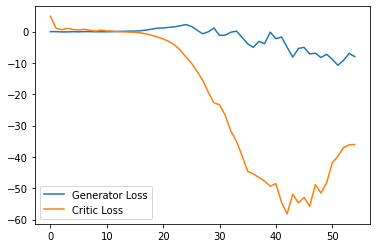

Step 1150: Generator loss: -8.104916441440583, critic loss: -36.51984995651245


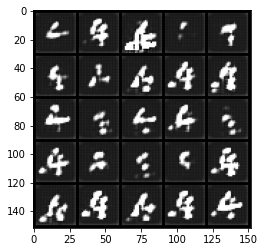

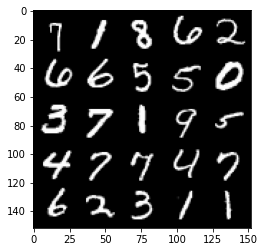

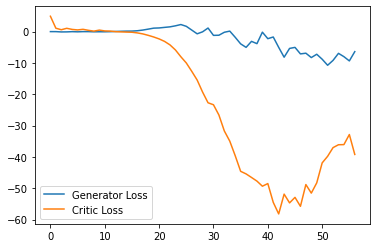

Step 1200: Generator loss: -8.747237917780875, critic loss: -33.11946008491516


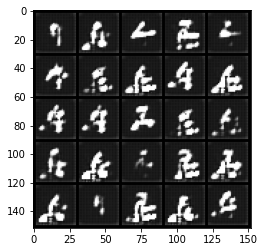

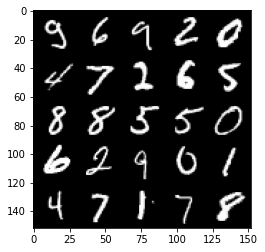

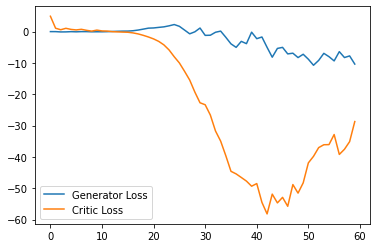

Step 1250: Generator loss: -5.371344751119613, critic loss: 21.94165247535706


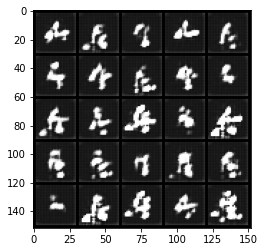

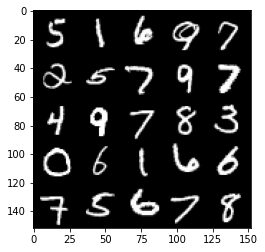

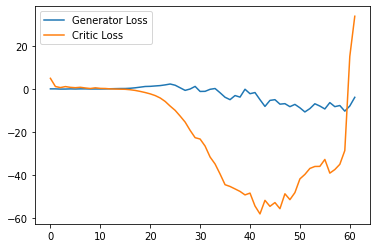

Step 1300: Generator loss: -3.8385422706604, critic loss: 2.6994850273132327


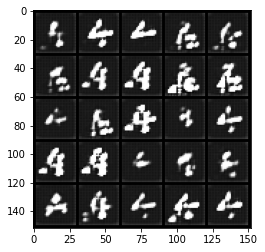

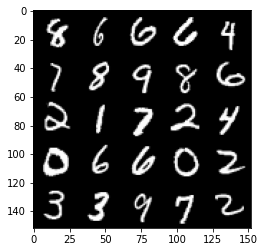

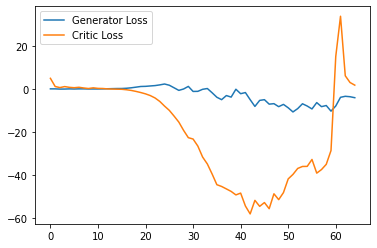

Step 1350: Generator loss: -5.5885905742645265, critic loss: 0.6500194671154021


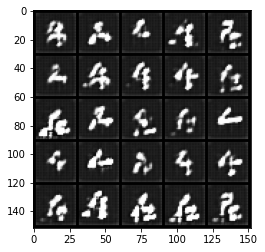

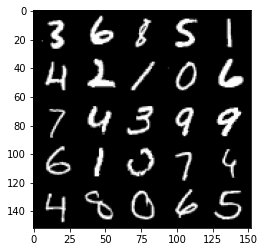

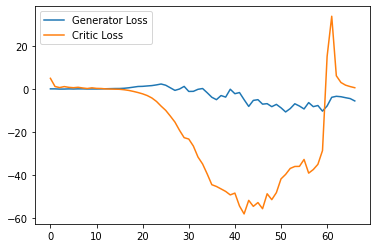

Step 1400: Generator loss: -9.427990674972534, critic loss: -0.24874457263946537


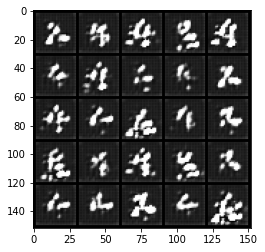

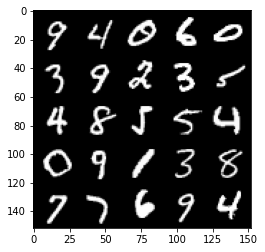

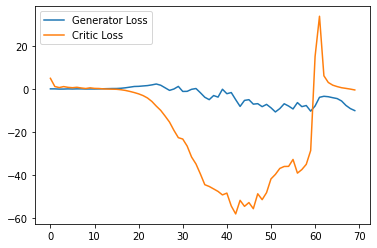

Step 1450: Generator loss: -11.112760314941406, critic loss: -0.8007753708362578


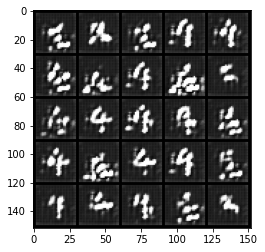

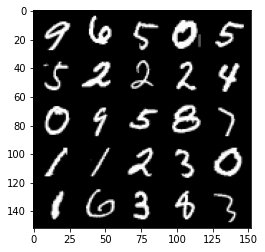

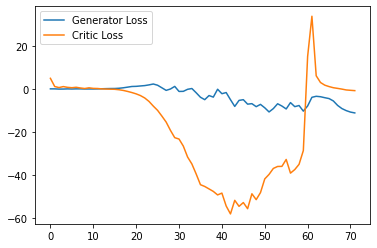

Step 1500: Generator loss: -11.422455368041993, critic loss: -1.3043164286613464


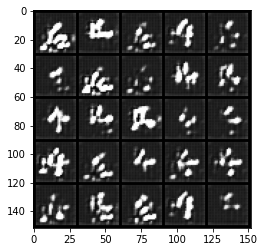

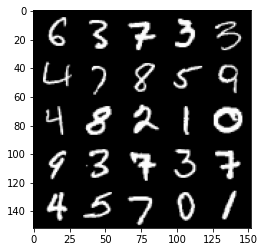

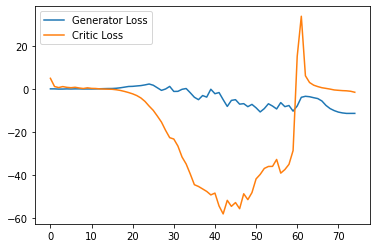

Step 1550: Generator loss: -11.480745334625244, critic loss: -2.254991483211517


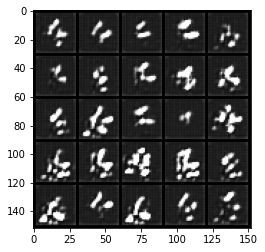

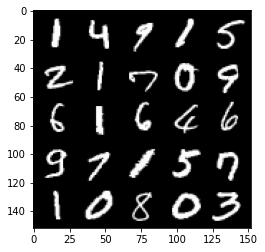

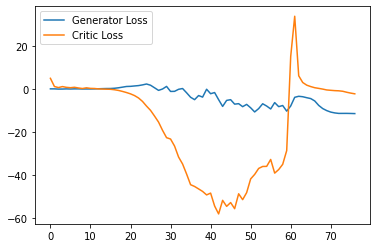

Step 1600: Generator loss: -12.059372024536133, critic loss: -3.7450345454216007


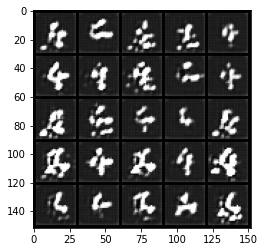

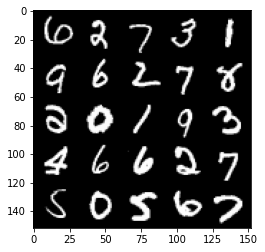

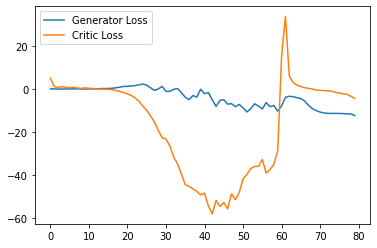

Step 1650: Generator loss: -12.07995590209961, critic loss: -5.995913361549377


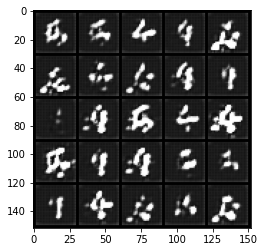

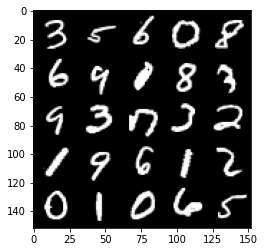

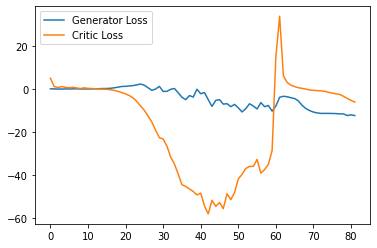

KeyboardInterrupt: ignored

In [111]:
import matplotlib.pyplot as plt

cur_step = 0
generator_losses = []
critic_losses = []
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        mean_iteration_critic_loss = 0
        for _ in range(crit_repeats):
            ### Update critic ###
            crit_opt.zero_grad()
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            crit_fake_pred = crit(fake.detach())
            crit_real_pred = crit(real)

            epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
            gradient = get_gradient(crit, real, fake.detach(), epsilon)
            gp = gradient_penalty(gradient)
            crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)

            # Keep track of the average critic loss in this batch
            mean_iteration_critic_loss += crit_loss.item() / crit_repeats
            # Update gradients
            crit_loss.backward(retain_graph=True)
            # Update optimizer
            crit_opt.step()
        critic_losses += [mean_iteration_critic_loss]

        ### Update generator ###
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        crit_fake_pred = crit(fake_2)
        
        gen_loss = get_gen_loss(crit_fake_pred)
        gen_loss.backward()

        # Update the weights
        gen_opt.step()

        # Keep track of the average generator loss
        generator_losses += [gen_loss.item()]

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            crit_mean = sum(critic_losses[-display_step:]) / display_step
            print(f"Step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Critic Loss"
            )
            plt.legend()
            plt.show()

        cur_step += 1